# This notebook removes the Leading Zeroes

In [36]:
from pathlib import Path
import pandas as pd
import re

In [37]:
#Get the list of all of the step files
step_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[dD][wW][iI]"))

#Get the list of all of the step files
song_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[mM][pP][3]"))

In [38]:
def process_song(path, title):
    #Open File
    text_file = open(path, "r")
    lines = text_file.readlines()
    text_file.close()
    
    #Combine all text into single line
    song = "".join(lines)
    
    #Remove newline characters
    song = re.sub('\n', '', song)
    
    #Split on semicolon and then add the semicolons back into the respective lines
    song = song.split(';')
    song = [line+';' for line in song][:-1]
    
    #Remove lines that start with 2 // (some files had this for some reason)
    song = [line for line in song if (line.find('//') == -1)]
    
    #Create a dataframe of the song
    df = pd.DataFrame()
    df[title] = song
    return df

def pull_all_step_patterns(song, row):
    song = song[row].str.split(":", n = 3, expand = True)
    song = song[song[0].isin(["#SINGLE","#SOLO"])]
    return song

def remove_leading_zeroes(song):
    """Take a song step file and remove the leading zeroes"""
    song[3] = song[3].str.replace(r"^0+","")
    return song

def join_all_step_patterns(step_files):
    """Create a dataframe of all songs for a fastai training model."""
    songs = pd.DataFrame()
    for row, path in enumerate(step_files):
        df = process_song(path, row)
        df = pull_all_step_patterns(df, row)
        songs = pd.concat([songs,df])
    
    songs[3] = songs[3].str.replace(r"^0+","")
    
    songs = fastaiFormat(songs)
    
    return songs

def fastaiFormat(songs):
    """Take a list of step files and make it into a format for fastai NLP"""
    songs = songs.reset_index()
    songs = songs[[1,3]]
    songs.columns = ['label','text']

    #Split the song into characters with spaces
    songs['text'] = songs['text'].apply(lambda x: " ".join(x))

    #Remove the trailing semicolon as we can add it back in when we are done predicting songs
    songs['text'] = songs['text'].apply(lambda x: x[:-1])
    
    return songs

In [39]:
songs = join_all_step_patterns(step_files)

In [40]:
songs.head()

,label,text
0,BEGINNER,6 0 6 0 0 0 0 0 4 0 4 0 0 0 6 0 0 0 4 0 0 0 0 ...
1,BASIC,8 0 6 0 8 0 4 0 8 0 6 0 0 0 0 0 6 0 0 0 6 0 B ...
2,ANOTHER,8 0 6 0 8 0 4 0 8 0 6 0 0 0 0 0 8 0 0 0 A 0 B ...
3,MANIAC,2 8 8 0 2 0 B 0 4 2 8 0 2 0 B 0 6 2 4 0 2 0 6 ...
4,SMANIAC,2 2 ( 8 0 0 2 ) 6 4 8 0 1 0 ( 6 0 0 4 ) 8 2 6 ...


In [41]:
songs.to_csv("songs_no_zero.csv", index=False)

# Train our Language Model

In [42]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

In [43]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [44]:
all_letters = list(string.printable + string.whitespace)

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(tokenizer=customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data = (TextList.from_csv(path, 'songs_no_zero.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_for_lm()
                .databunch(bs=192))
data.save('data_block_lm3.pkl')

In [45]:
data_lm = load_data(path, 'data_block_lm3.pkl',bs=192)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


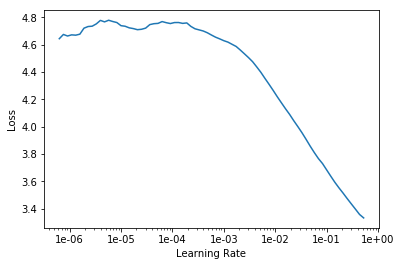

In [46]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [47]:
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.478136,1.666726,0.490652,00:10
1,1.879491,1.469366,0.511452,00:10
2,1.638249,1.392691,0.525629,00:10
3,1.516109,1.351767,0.535403,00:10
4,1.453140,1.342484,0.539096,00:10
5,1.420458,1.332846,0.541721,00:10
6,1.404704,1.344610,0.537466,00:10
7,1.386753,1.316883,0.545346,00:10
8,1.374035,1.312088,0.547944,00:11
9,1.372337,1.311657,0.548681,00:10


In [48]:
learn.save('fit_head_3')

In [49]:
learn.unfreeze()

In [50]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.349128,1.298819,0.551529,00:14
1,1.329340,1.267281,0.559037,00:14
2,1.292467,1.230743,0.570786,00:14
3,1.255815,1.212191,0.576529,00:14
4,1.227565,1.192450,0.583455,00:14
5,1.201999,1.176046,0.589624,00:14
6,1.192392,1.169546,0.592066,00:14
7,1.170740,1.160979,0.595265,00:14
8,1.159789,1.156886,0.596882,00:14
9,1.150634,1.155324,0.596462,00:14


In [51]:
learn.save('fine_tuned_3')
learn.save_encoder('fine_tuned_enc_3')

In [52]:
TEXT = ""
N_WORDS = 200
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 D 0 C 0 D 0 C 0 D 0 D 0 8 0 2 0 4 0 2 0 8 0 6 0 C 0 6 0 2 0 C 0 6 0 2 0 4 0 8 0 8 0 2 0 6 0 2 0 4 0 2 0 2 0 8 0 6 0 2 0 C 0 D 0 D 0 0 0 0 0 0 0 4 0 0 0 2 0 0 0 C 0 0 0 8 0 0 0 4 0 2 0 2 0 J 0 0 0 8 0 B 0 2 0 2 0 2 0 B 0 2 0 2 0 8 0 6 0 0 0 D 0 D 0 C 0 8 0 2 0 2 0 8 0 8 0 8 0 8 0 8 0 2 0 8 0 C 0 8 0 8 0 2 0 6 0 C 0 C 0 2 0 2 0 6 0 2 0 C 0 8 0 2 0 B 0 2 0 D 0 D 0 B 0 C 0 C 0 2 0 D 0 D 0 D 0 4 0 4 0


# Now we work on the classifier

In [53]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [54]:
#Try out the datablock API to see if we can replicate and use either no tokenization or our custom tokenizer
all_letters = list(string.printable + string.whitespace)

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(tokenizer=customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data_clas = (TextList.from_csv(path, 'songs.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_from_df('label')
                .databunch(bs=12))
data_clas.save('data_clas_3.pkl')

In [55]:
data_clas = load_data(path, 'data_clas_3.pkl', bs=12)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc_3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


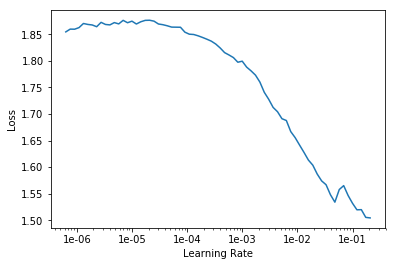

In [56]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [57]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.101338,0.790516,0.749164,01:01
1,0.855873,0.846046,0.692308,01:00
2,0.767616,0.643379,0.779264,01:01
3,0.762706,0.739143,0.725753,01:02
4,0.731602,0.618340,0.782609,01:00
5,0.727014,0.689815,0.752508,01:01
6,0.668333,0.679828,0.749164,01:01
7,0.640314,0.652950,0.772575,01:00
8,0.610352,0.659151,0.775920,01:00
9,0.606961,0.634655,0.775920,01:01


In [58]:
learn.save('classifier_3')

In [59]:
learn.unfreeze()

In [60]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.628235,0.668624,0.772575,01:28
1,0.636625,0.575484,0.809365,01:28
2,0.718957,0.703777,0.722408,01:29
3,0.705603,0.581863,0.812709,01:28
4,0.660555,0.598923,0.782609,01:29
5,0.696981,0.590564,0.789298,01:30
6,0.644985,0.547766,0.802676,01:29
7,0.605895,0.572895,0.779264,01:29
8,0.587646,0.556502,0.799331,01:29
9,0.595241,0.577947,0.799331,01:28


In [61]:
learn.save('fine_tuned_classifier_3')
learn.save_encoder('fine_tuned_enc_classifier_3')

## What are the most frequently misclassified?

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

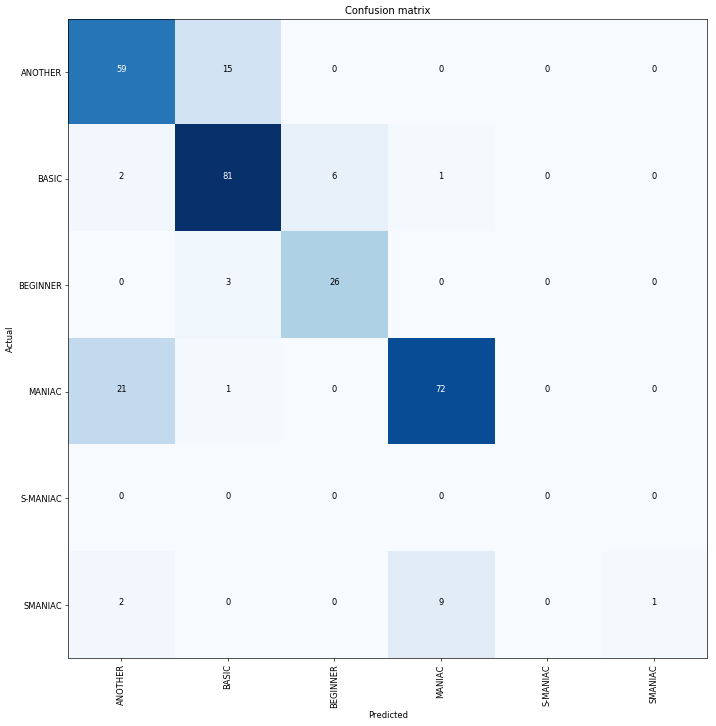

In [63]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [64]:
interp.most_confused(min_val=2)

[('MANIAC', 'ANOTHER', 21),
 ('ANOTHER', 'BASIC', 15),
 ('SMANIAC', 'MANIAC', 9),
 ('BASIC', 'BEGINNER', 6),
 ('BEGINNER', 'BASIC', 3),
 ('BASIC', 'ANOTHER', 2),
 ('SMANIAC', 'ANOTHER', 2)]